In [1]:
import numpy as np
import os, shutil
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
import qpsolvers
import quadprog
import time
from scipy.optimize import minimize
import copy
import sys
import platform
# Importing other files
#sys.path.insert(1,'C:/...file_address')
import BeamPropertiesClass as bp
import ObstaclePropertiesClass as op
import BeamModelClass as bm
import TimeIntegrationClass as tim
#import parameters_dumont_paoli as pm


if __name__ == '__main__':
        # ----------- Constants ------------

        E = 2*10**11 # Constant Young Modulus
        diam_max = 0.01   # Cylindrical beam - Outer circle
        diam_min = 0.009  # Cylindrical beam - Inner circle
        I = (np.pi/64)*(diam_max**4-diam_min**4) # Inertia Moment
        S = np.pi*((diam_max/2)**2-(diam_min/2)**2) # Section Area
        rho = 8000   # Density
        alpha = 1e-4 # Damping Coefficient

        # ----------- Space discretised beam model ------------
        L  = 1.501  # Total Length
        Nbel = 6   # Number of Elements
        mass_matrix_type = 'Singular'

        # ----------- Time discretised beam model ------------
        dt    = 0.01
        tmax  = 3.0
        amp   = 0.2
        omega = 10.0
        beta  = 1/4
        e     = 0
        solve_method = 'Penalty' # 'Lagrangian'
        epsilonp = 1e-4

        # ------------ Initial Conditions --------------------
        u0 = np.poly1d([0]) # lambda x: 0
        v0 = np.poly1d([0]) # lambda x: 0
    
        # -------------------- Classes -------------------
        BP = bp.BeamProperties(E,I,rho,S,alpha) # BeamProperties class element
        OP = op.ObstacleProperties(1,-1, 2*Nbel, L) # ObstacleProperties class element
        BM = bm.DumontPaoliBeamModel(L, Nbel, mass_matrix_type, BP)
        TIM = tim.TimeIntegrationModel(BM, OP, u0, v0, dt, tmax, amp, omega, beta, e, solve_method, epsilonp)

        # --------------------Tests------------------
        Qn = 1.5*np.ones(2 * Nbel)
        x = np.linspace(0,L,Nbel+1)
        
        P = TIM.compute_FirstTermMatrix()

        r = TIM.penalty_force(np.array(Nbel//2*[2,0,-3,0]))

        print(OP.contact_test(Qn))
        print(BP.Density([1]))
        print(BM.E)
        print(r)

(True, array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
[8000.]
[2.e+11 2.e+11 2.e+11 2.e+11 2.e+11 2.e+11]
[-10000.     -0.  20000.     -0. -10000.     -0.  20000.     -0. -10000.
     -0.  20000.     -0.]


[3.426412545933981, 30.090691519859377, 55.42691694096315, 27.598533373237352, 18.15236245142295, 39.71403374985825, 38.75853277936297, 26.089342975352327, -18.536742958770446, 3.2103976094119413, -2.7787010763319353, -24.916432584854984, -54.494281885825444, -55.59535449923797, -35.593991690977546, -55.33643482995398, -75.202085669063, -61.220497645963206]


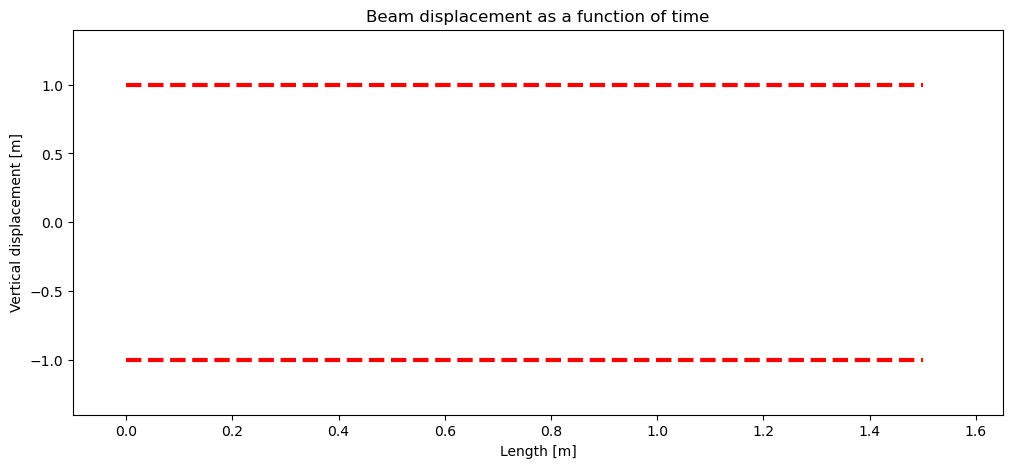

In [14]:
tn, Vn, U, Et, Rt, Ut, Vt, Uddt = 0, np.zeros(Nbel), [np.zeros(2*Nbel)], [], [], [], [], []
for i in range(17):
    TIM.iterate()
print(TIM.Uddt)
TIM.plot_animation()

# Dumont-Paoli Model explained

At first, the $\textbf{Euler-Bernoulli}$ Beam Model gets discretised using the $\textbf{Finite Element Method}$:


$$
\begin{cases}
    &\text{Find } U : [0, T] \to \mathbb{K}^h \text{ and } V : [0, T] \to \mathbb{V}^h \text{ such that } \forall t \in ]0, T]: \\
    &(W - U(t))^T \big(M \ddot{U}(t) + A \dot{U}(t) + K U(t)\big) \geq (W - U(t))^T F(t), &\forall W \in \mathbb{K}^h, \\
    &C V(t) = B \dot{U}(t), \\
    &U(0) = U_0, \quad V(0) = V_0,
\end{cases}
$$

With the original model being:
The strong formulation of the contact problem is expressed as follows:

$\to$ Find $u \in \mathbb{K}$ and $r \in \mathbb{W}'$ such that:
$$
    \begin{cases}
    \rho\,S\,\dfrac{\partial^2 u}{\partial t^2}
    \;+\;
    \dfrac{\partial^2}{\partial x^2}
      \left(\alpha\,E\,I\,\dfrac{\partial^3 u}{\partial x^2\,\partial t} \right)
    \;+\;
    \dfrac{\partial^2}{\partial x^2}
      \left(E\,I\,\dfrac{\partial^2 u}{\partial x^2}\right)
    \;=\; f \;-\; r,
    \\[6pt]
    u(x,0) = u_0(x),
    \quad
    \dot{u}(x,0) = v_0(x),
    &\forall x \in [0,L],\\[6pt]
    u(0,t) = 0,\quad
    \dfrac{\partial u}{\partial x}(0,t) = 0,\quad
    \dfrac{\partial^k u}{\partial x^k}(L,t) = 0,\quad \forall k\in\{2,3\},
    &\forall t\in[0,T],\\[6pt]
    [\,r\,]_- \;\bot\; (\,u - g_1\,)\ge 0,\quad
    [\,r\,]_+ \;\bot\; (\,g_2 - u\,)\ge 0.
    \end{cases}
$$
$\mathbb{K}$ is the set of admissible displacements.
$\mathbb{W}'$ is the dual of the displacements space $\mathbb{W}$ in which $\mathbb{K}$ is included!

The excitation function can be written as the following:
$f(x,t) = \mu (1-x) \omega^2 \sin (\omega t) $

## Construction of the matrices $M, A$ and $K$ and the second-term $F$


For an element $e=[x_{i-1},x_i]$:

$$
\int_{x_{i-1}}^{x_{i}} (1-x) \overrightarrow{N}_e (x) \, dx = \begin{bmatrix}
\frac{h}{2} \left[ \frac{N-i+1}{N} + \frac{h}{5 L} \right] \\
h^2 \left[ \frac{N-i+1}{12 N} - \frac{h}{80 L} + \frac{h}{48 N L} \right] \\
\frac{h}{2} \left[ \frac{N-i+1}{N} - \frac{h}{5 L} \right] \\
h^2 \left[ - \frac{N-i+1}{12 N} - \frac{h}{80 L} + \frac{h}{48 N L} \right] 
\end{bmatrix}
$$